In [1]:
import numpy as nmp
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from scipy.interpolate import BSpline, splrep, splev

In [2]:
airquality=pd.read_csv("C:/Users/arab/Downloads/airquality.csv")
airquality=airquality[['Ozone','Solar.R','Wind','Temp']]
airquality=airquality.dropna()
airquality.head()

,Ozone,Solar.R,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
6,23.0,299.0,8.6,65


In [3]:
airquality['TWcp']=airquality['Temp']*airquality['Wind']
airquality['TWrat']=airquality['Temp']/airquality['Wind']
airquality.head()

,Ozone,Solar.R,Wind,Temp,TWcp,TWrat
0,41.0,190.0,7.4,67,495.8,9.054054
1,36.0,118.0,8.0,72,576.0,9.000000
2,12.0,149.0,12.6,74,932.4,5.873016
3,18.0,313.0,11.5,62,713.0,5.391304
6,23.0,299.0,8.6,65,559.0,7.558140


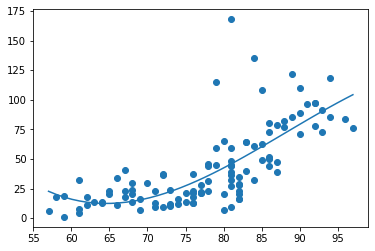

In [4]:
x_temp=airquality['Temp']
y_o=airquality['Ozone']
poly=nmp.poly1d(nmp.polyfit(x_temp,y_o,3))
plt.scatter(x_temp,y_o)
lin=nmp.linspace(x_temp.min(),x_temp.max(),x_temp.max()-x_temp.min())
plt.plot(lin,poly(lin))

B-Spline1 r-MSPE:  19.79399323444956
B-Spline2 r-MSPE:  19.632210096710867
B-Spline3 r-MSPE:  21.170369351818366
B-Spline4 r-MSPE:  33.291623581917115


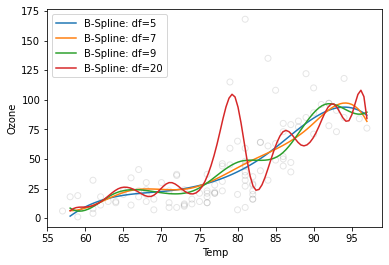

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(airquality['Temp'], airquality['Ozone'], test_size=0.33, random_state=1)

from patsy import dmatrix 
import statsmodels.api as sm


transformed_x_bs1 = dmatrix("bs(train, df=5, degree=3)", {"train": train_x}, return_type='dataframe')
transformed_x_bs2 = dmatrix("bs(train, df=7, degree=3)", {"train": train_x}, return_type='dataframe')
transformed_x_bs3 = dmatrix("bs(train, df=9, degree=3)", {"train": train_x}, return_type='dataframe')
transformed_x_bs4 = dmatrix("bs(train, df=20, degree=3)", {"train": train_x}, return_type='dataframe')


# fitting generalized linear model on transformed dataset
fit_bs1 = sm.GLM(train_y, transformed_x_bs1).fit()
fit_bs2 = sm.GLM(train_y, transformed_x_bs2).fit()
fit_bs3 = sm.GLM(train_y, transformed_x_bs3).fit()
fit_bs4 = sm.GLM(train_y, transformed_x_bs4).fit()


# predictions on both splines
pred_bs1 = fit_bs1.predict(dmatrix("bs(valid, df=5, degree=3)", {"valid":valid_x}, return_type='dataframe'))
pred_bs2 = fit_bs2.predict(dmatrix("bs(valid, df=7, degree=3)", {"valid":valid_x}, return_type='dataframe'))
pred_bs3 = fit_bs3.predict(dmatrix("bs(valid, df=9, degree=3)", {"valid":valid_x}, return_type='dataframe'))
pred_bs4 = fit_bs4.predict(dmatrix("bs(valid, df=20, degree=3)", {"valid":valid_x}, return_type='dataframe'))


# calculating rmse
rms_bs1 = np.sqrt(mean_squared_error(valid_y, pred_bs1))
rms_bs2 = np.sqrt(mean_squared_error(valid_y, pred_bs2))
rms_bs3 = np.sqrt(mean_squared_error(valid_y, pred_bs3))
rms_bs4 = np.sqrt(mean_squared_error(valid_y, pred_bs4))

print('B-Spline1 r-MSPE: ', rms_bs1)
print('B-Spline2 r-MSPE: ', rms_bs2)
print('B-Spline3 r-MSPE: ', rms_bs3)
print('B-Spline4 r-MSPE: ', rms_bs4)


# we wil plot the graph for 70 observations only
xp = np.linspace(valid_x.min(), valid_x.max(), 100)

# make some predictions
pred_bs1 = fit_bs1.predict(dmatrix("bs(xp, df=5, degree=3)", {"xp":xp}, return_type='dataframe'))
pred_bs2 = fit_bs2.predict(dmatrix("bs(xp, df=7, degree=3)", {"xp":xp}, return_type='dataframe'))
pred_bs3 = fit_bs3.predict(dmatrix("bs(xp, df=9, degree=3)", {"xp":xp}, return_type='dataframe'))
pred_bs4 = fit_bs4.predict(dmatrix("bs(xp, df=20, degree=3)", {"xp":xp}, return_type='dataframe'))
# plot the splines and error bands
plt.scatter(airquality.Temp, airquality.Ozone, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred_bs1, label='B-Spline: df=5')
plt.plot(xp, pred_bs2, label='B-Spline: df=7')
plt.plot(xp, pred_bs3, label='B-Spline: df=9')
plt.plot(xp, pred_bs4, label='B-Spline: df=20')
plt.legend()
plt.xlabel('Temp')
plt.ylabel('Ozone')
plt.show()

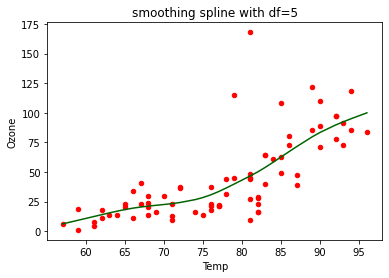

In [6]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_df = r_smooth_spline(r_train_x, r_train_y, df=5)

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with df=5")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_df.rx2("x"),sSpline_df.rx2("y"),color="darkgreen");

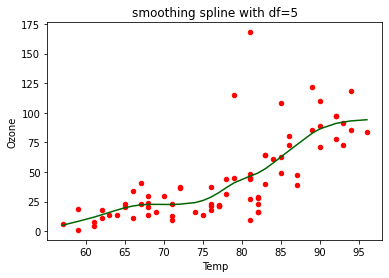

In [7]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_df = r_smooth_spline(r_train_x, r_train_y, df=7)

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with df=5")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_df.rx2("x"),sSpline_df.rx2("y"),color="darkgreen");

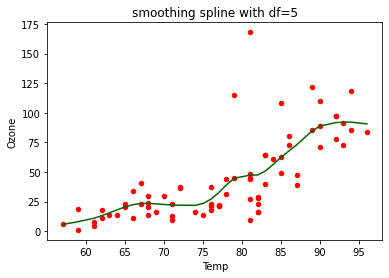

In [8]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_df = r_smooth_spline(r_train_x, r_train_y, df=9)

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with df=5")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_df.rx2("x"),sSpline_df.rx2("y"),color="darkgreen");

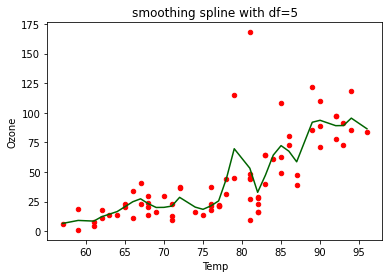

In [9]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_df = r_smooth_spline(r_train_x, r_train_y, df=20)

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with df=5")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_df.rx2("x"),sSpline_df.rx2("y"),color="darkgreen");

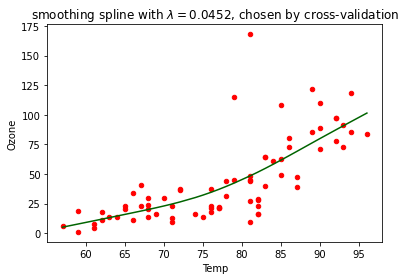

In [10]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_cv = r_smooth_spline(r_train_x, r_train_y, cv=True)
lambda_cv = sSpline_cv.rx2("lambda")[0]

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with $\lambda=$"+str(np.round(lambda_cv,4))+", chosen by cross-validation")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_cv.rx2("x"),sSpline_cv.rx2("y"),color="darkgreen");

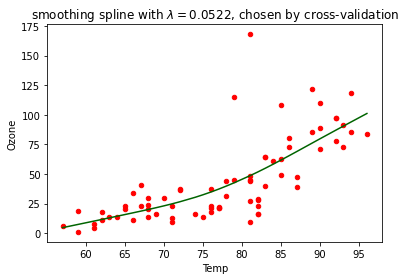

In [11]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Temp":train_x, "Ozone":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_cv = r_smooth_spline(r_train_x, r_train_y, cv=False)
lambda_cv = sSpline_cv.rx2("lambda")[0]

ax19 = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="smoothing spline with $\lambda=$"+str(np.round(lambda_cv,4))+", chosen by cross-validation")
ax19.set_xlabel("Temp")
ax19.set_ylabel("Ozone")
ax19.plot(sSpline_cv.rx2("x"),sSpline_cv.rx2("y"),color="darkgreen");

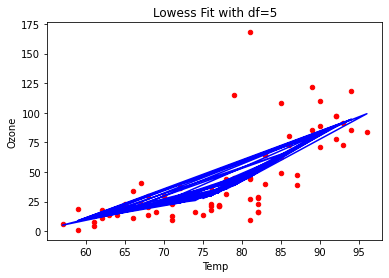

In [12]:
r_loess = robjects.r['loess'] #extract R function
r_loess_pred = robjects.r['predict'] #extract R function

from rpy2.robjects import pandas2ri
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter):
  r_train_df = robjects.conversion.py2rpy(pd_train_df)

loess_1 = r_loess(formula="Ozone~Temp", data=r_train_df, enp_target=5)
loess_1_pred = r_loess_pred(loess_1)
ax = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="Lowess Fit with df=5")
ax.set_xlabel("Temp")
ax.set_ylabel("Ozone")
ax.plot(train_x, loess_1_pred, color="blue")
plt.show()

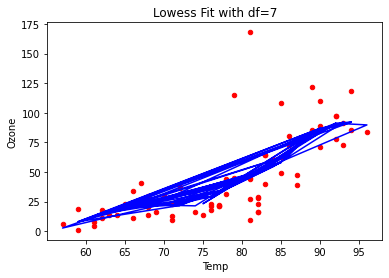

In [13]:
r_loess = robjects.r['loess'] #extract R function
r_loess_pred = robjects.r['predict'] #extract R function

from rpy2.robjects import pandas2ri
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter):
  r_train_df = robjects.conversion.py2rpy(pd_train_df)

loess_1 = r_loess(formula="Ozone~Temp", data=r_train_df, enp_target=7)
loess_1_pred = r_loess_pred(loess_1)
ax = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="Lowess Fit with df=7")
ax.set_xlabel("Temp")
ax.set_ylabel("Ozone")
ax.plot(train_x, loess_1_pred, color="blue")
plt.show()

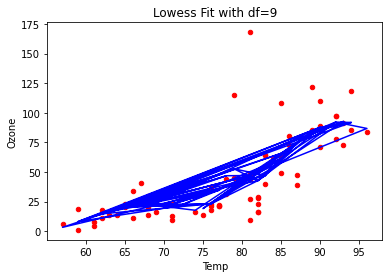

In [14]:
r_loess = robjects.r['loess'] #extract R function
r_loess_pred = robjects.r['predict'] #extract R function

from rpy2.robjects import pandas2ri
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter):
  r_train_df = robjects.conversion.py2rpy(pd_train_df)

loess_1 = r_loess(formula="Ozone~Temp", data=r_train_df, enp_target=9)
loess_1_pred = r_loess_pred(loess_1)
ax = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="Lowess Fit with df=9")
ax.set_xlabel("Temp")
ax.set_ylabel("Ozone")
ax.plot(train_x, loess_1_pred, color="blue")
plt.show()

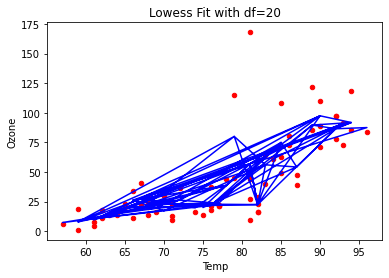

In [18]:
r_loess = robjects.r['loess'] #extract R function
r_loess_pred = robjects.r['predict'] #extract R function

from rpy2.robjects import pandas2ri
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter):
  r_train_df = robjects.conversion.py2rpy(pd_train_df)

loess_1 = r_loess(formula="Ozone~Temp", data=r_train_df, enp_target=20)
loess_1_pred = r_loess_pred(loess_1)
ax = pd_train_df.plot.scatter(x='Temp',y='Ozone',c='Red',title="Lowess Fit with df=20")
ax.set_xlabel("Temp")
ax.set_ylabel("Ozone")
ax.plot(train_x, loess_1_pred, color="blue")
plt.show()